LALSuite: A collection of libraries and programs for gravitational wave data analysis. It's developed by the LIGO Scientific Collaboration.

PyCBC: A package used in the analysis of gravitational wave data, particularly from the LIGO and Virgo experiments.

giotto-tda: A library for topological data analysis (TDA). It's useful for machine learning tasks that involve complex data.

ripser: A lean C++ code for the computation of Vietoris–Rips persistence barcodes.

In [ ]:
# pip -q install colorednoise
# pip -q install matplotlib-venn
# apt-get -qq install -y libfluidsynth
# apt-get -qq install -y libarchive-dev && pip install -U libarchive
# apt-get -qq install -y graphviz && pip install pydot

!pip -q install lalsuite pycbc
!pip install -U giotto-tda
# pip3 -q install gudhi
!pip -q install ripser
# pip -q install persim

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.ndimage import gaussian_filter as gf
import matplotlib.pyplot as plt
from scipy import interpolate
from tqdm import tqdm
import pandas as pd
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import pycbc.noise
import pycbc.psd
from ripser import ripser
from gtda.time_series import SingleTakensEmbedding
from ripser import ripser
from tqdm import tqdm

method = ['slinear', 'quadratic'][0]
def interpolation(h,t,tmin,tmax,delta_t,method='slinear'):
  f = interpolate.interp1d(t, h,method)
  tnew = np.arange(tmin, tmax, delta_t)
  hnew = f(tnew)
  return tnew,hnew

def ens_interpolation(h,t,tmin,tmax,delta_t):
  tp_interpol,hp_interpol_1 = interpolation(h,t,tmin,tmax,delta_t,method='slinear')
  tp_interpol,hp_interpol_2 = interpolation(h,t,tmin,tmax,delta_t,method='quadratic')
  hp_interpol = (hp_interpol_1 + hp_interpol_2)/2
  return tp_interpol,hp_interpol

np.linspace(0,np.pi,9)/np.pi

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

gravitational wave simulation baced on gravitational wave detections in a LIGO  detectors and noise generation.

approximant_methods = SEOBNRv4_opt


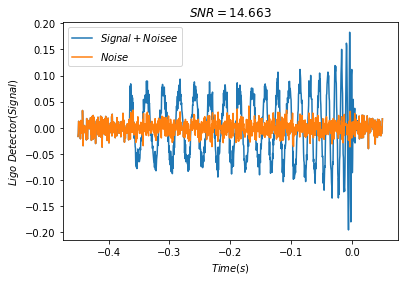

In [ ]:
from scipy.ndimage import gaussian_filter as gf
import matplotlib.pyplot as plt
from scipy import interpolate
from tqdm import tqdm
import pandas as pd
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import pycbc.noise
import pycbc.psd
from ripser import ripser
from gtda.time_series import SingleTakensEmbedding
from ripser import ripser
from tqdm import tqdm

method = ['slinear', 'quadratic'][0]
def interpolation(h,t,tmin,tmax,delta_t,method='slinear'):
  f = interpolate.interp1d(t, h,method)
  tnew = np.arange(tmin, tmax, delta_t)
  hnew = f(tnew)
  return tnew,hnew

def ens_interpolation(h,t,tmin,tmax,delta_t):
  tp_interpol,hp_interpol_1 = interpolation(h,t,tmin,tmax,delta_t,method='slinear')
  tp_interpol,hp_interpol_2 = interpolation(h,t,tmin,tmax,delta_t,method='quadratic')
  hp_interpol = (hp_interpol_1 + hp_interpol_2)/2
  return tp_interpol,hp_interpol

# fix parameter
res = 2048 # resolution
flow = 30.0 # low frequency cutoff
delta_f = 1.0 / 16
flen = int(res / delta_f) + 1  # f_samples
tmin = -0.45
tmax = 0.05
w_noise = 1.0
res = 2048.0
delta_t = 1.0 / res
factor = 1e20
# ligo detector
declination = 0.65
right_ascension = 4.67
polarization = 2.34
det_l1 = Detector('L1')

approximant_method = 'SEOBNRv4_opt'
print(f'approximant_methods = {approximant_method}')

sample_index = 1
mass1 = np.linspace(10,100,10)[sample_index]
mass2 = np.linspace(10,100,10)[sample_index]

inclination = np.linspace(0,np.pi,9)[sample_index]
coa_phase = np.linspace(0,np.pi,9)[sample_index]
distance = [10,50,100,200,300,500,700,1000,2000,3000][sample_index]

# mass1 = 10
# mass2 = np.linspace(10,100,10)[sample_index]
# mass_ratio = mass1/mass2
f_lower = 35

hp, hc = get_td_waveform( approximant=approximant_method,
                        mass1=mass1,
                        mass2=mass2,
                        inclination=inclination,
                        coa_phase=coa_phase,
                        delta_t=delta_t,
                        distance=distance,
                        f_lower=f_lower)

time_p = hp.sample_times
time_c = hc.sample_times

signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
time_l1 = signal_l1.sample_times

min_sim_time = np.min(np.array(time_l1))
max_sim_time = np.max(np.array(time_l1))
delta_tt = time_l1[1]-time_l1[0]

time_l1 = list(time_l1)
start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

time_l1 = start_t + time_l1 + end_t
time_l1 = np.array(time_l1)

signal_l1 = list(signal_l1)
signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
signal_l1 = np.array(signal_l1)

time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
tsamples =  len(h_range)#int(len_signal / delta_t) + 1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
h_range = h_range*factor
signal = h_range + noise_signal_weighted

plt.plot(time_p_range,signal,label=r'$Signal+Noisee$')
plt.plot(time_p_range,noise_signal_weighted,label=r'$Noise$')

plt.xlabel('$Time(s)$')
plt.ylabel('$Ligo\ Detector(Signal)$')
plt.title(fr'$SNR={np.round(np.var(h_range)/np.var(noise_signal_weighted),3)}$')
plt.legend();

In [ ]:
signal_data = np.load('/content/drive/MyDrive/TDA_Esfahanian/data_sim/signal_data.npz')['data'][[0,2,15]]
noise_data = np.load('/content/drive/MyDrive/TDA_Esfahanian/data_sim/noise_data.npz')['data'][[0,2,15]]
df = pd.read_csv('/content/drive/MyDrive/TDA_Esfahanian/data_sim/df_label.csv')

list_snr = df['SNR'].values[[0,2,15]]

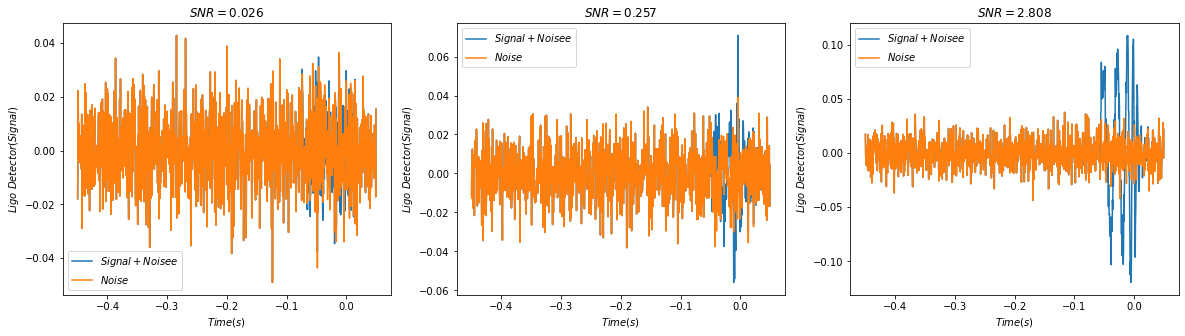

In [ ]:
plt.figure(figsize=(20,5))
for i in range(3):
  h_range = signal_data[i]
  noise_signal_weighted = noise_data[i]
  signal = h_range + noise_signal_weighted

  plt.subplot(1,3,i+1)
  plt.plot(time_p_range,signal,label=r'$Signal+Noisee$')
  plt.plot(time_p_range,noise_signal_weighted,label=r'$Noise$')

  plt.xlabel('$Time(s)$')
  plt.ylabel('$Ligo\ Detector(Signal)$')
  plt.title(fr'$SNR={np.round(np.var(h_range)/np.var(noise_signal_weighted),3)}$')
  plt.legend()
plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/SNR.jpg',dpi=250,bbox_inches='tight');

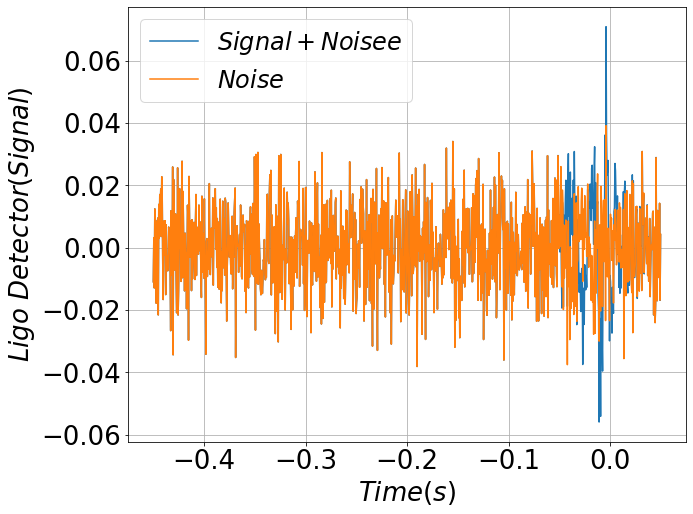

In [ ]:
plt.figure(figsize=(10,8))
for i in range(1,2):
  h_range = signal_data[i]
  noise_signal_weighted = noise_data[i]
  signal = h_range + noise_signal_weighted

  plt.subplot(1,1,i)
  plt.plot(time_p_range,signal,label=r'$Signal+Noisee$')
  plt.plot(time_p_range,noise_signal_weighted,label=r'$Noise$')
  plt.xticks(fontsize=26)
  plt.yticks(fontsize=26)
  plt.xlabel('$Time(s)$',size=26)
  plt.ylabel('$Ligo\ Detector(Signal)$',size=26)
  # plt.title(fr'$SNR={np.round(np.var(h_range)/np.var(noise_signal_weighted),3)}$')
  plt.grid()
  plt.legend(fontsize=24)
plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/iran_paper/SNR.jpg',dpi=250,bbox_inches='tight');

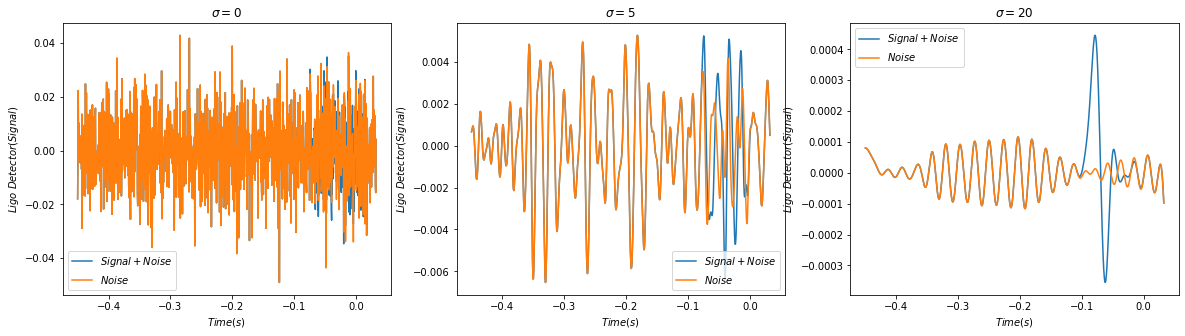

In [ ]:
from scipy.ndimage import gaussian_filter as gf
i = 0
plt.figure(figsize=(20,5))
for s_i in [0,5,20]:
  h_range = signal_data[0]
  noise_signal_weighted = noise_data[0]
  signal = gf(h_range + noise_signal_weighted,s_i)
  noise_signal_weighted = gf(noise_data[0],s_i)
  i += 1
  plt.subplot(1,3,i)
  plt.plot(time_p_range[:-35],signal[:-35],label=r'$Signal+Noise$')
  plt.plot(time_p_range[:-35],noise_signal_weighted[:-35],label=r'$Noise$')

  plt.xlabel('$Time(s)$')
  plt.ylabel('$Ligo\ Detector(Signal)$')
  plt.title(fr'$\sigma={np.round(np.var(signal-noise_signal_weighted)/np.var(noise_signal_weighted),3)}$')
  plt.title(fr'$\sigma={s_i}$')
  plt.legend()
plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/SNR_with_sigma.jpg',dpi=250,bbox_inches='tight');

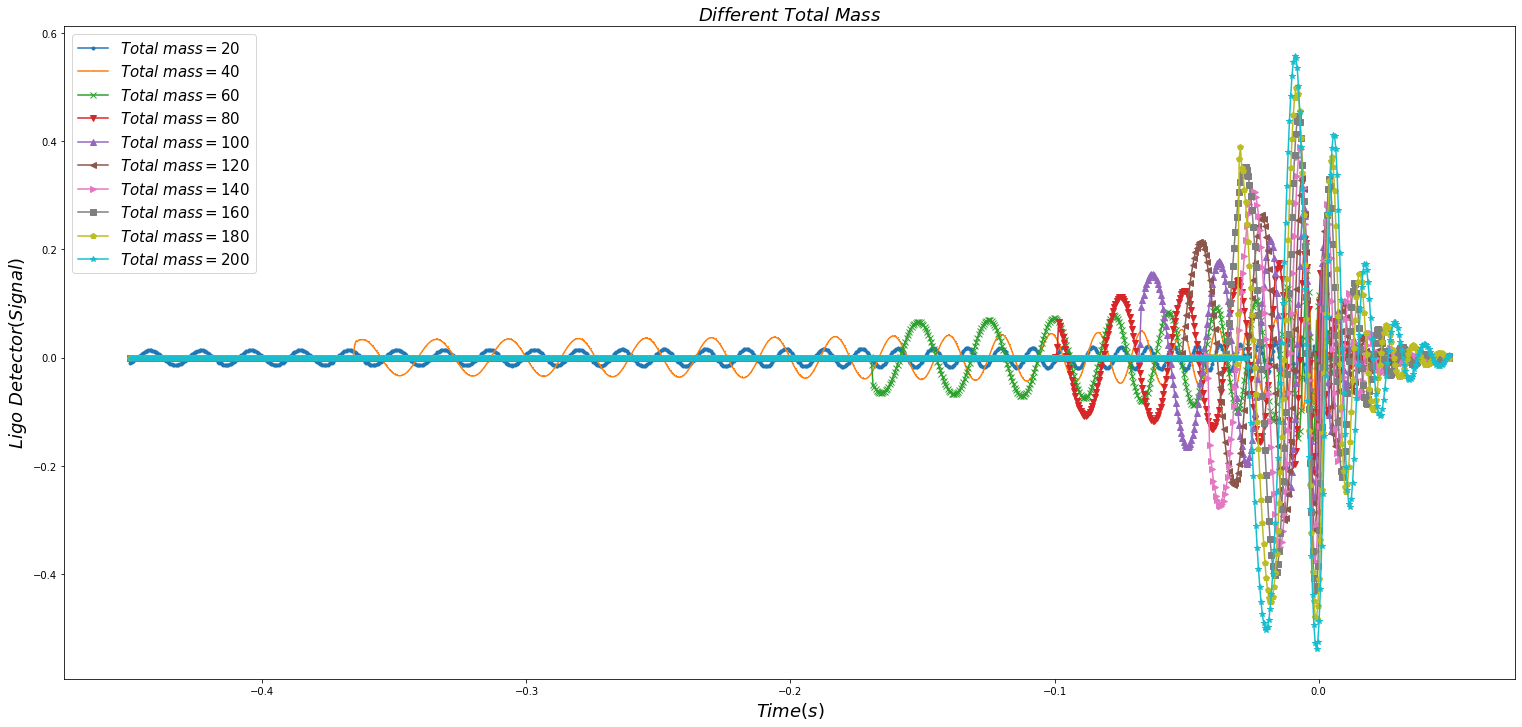

In [ ]:
# Total mass
marker = [".",",","x","v","^","<",">","s","p","*"]
plt.figure(figsize=(26,12))
for sample_index in range(10):
  mass1 = np.linspace(10,100,10)[sample_index]
  mass2 = np.linspace(10,100,10)[sample_index]

  inclination = 0
  coa_phase = 0
  distance = 100

  hp, hc = get_td_waveform( approximant=approximant_method,
                          mass1=mass1,
                          mass2=mass2,
                          inclination=inclination,
                          coa_phase=coa_phase,
                          delta_t=delta_t,
                          distance=distance,
                          f_lower=f_lower)

  time_p = hp.sample_times
  time_c = hc.sample_times

  signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
  time_l1 = signal_l1.sample_times

  min_sim_time = np.min(np.array(time_l1))
  max_sim_time = np.max(np.array(time_l1))
  delta_tt = time_l1[1]-time_l1[0]

  time_l1 = list(time_l1)
  start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
  end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

  time_l1 = start_t + time_l1 + end_t
  time_l1 = np.array(time_l1)

  signal_l1 = list(signal_l1)
  signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
  signal_l1 = np.array(signal_l1)

  time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

  len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
  tsamples =  len(h_range)#int(len_signal / delta_t) + 1

  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

  noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
  noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
  h_range = h_range*factor
  signal = h_range

  plt.plot(time_p_range,signal,label=fr'$Total\ mass={int(mass1+mass2)}$',marker=marker[sample_index])

  plt.xlabel('$Time(s)$',size=18)
  plt.ylabel('$Ligo\ Detector(Signal)$',size=18)
  plt.title(fr'$Different\ Total\ Mass$',size=18)
  plt.legend(fontsize=15)
  plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/Total_mass.jpg',dpi=200,bbox_inches='tight');

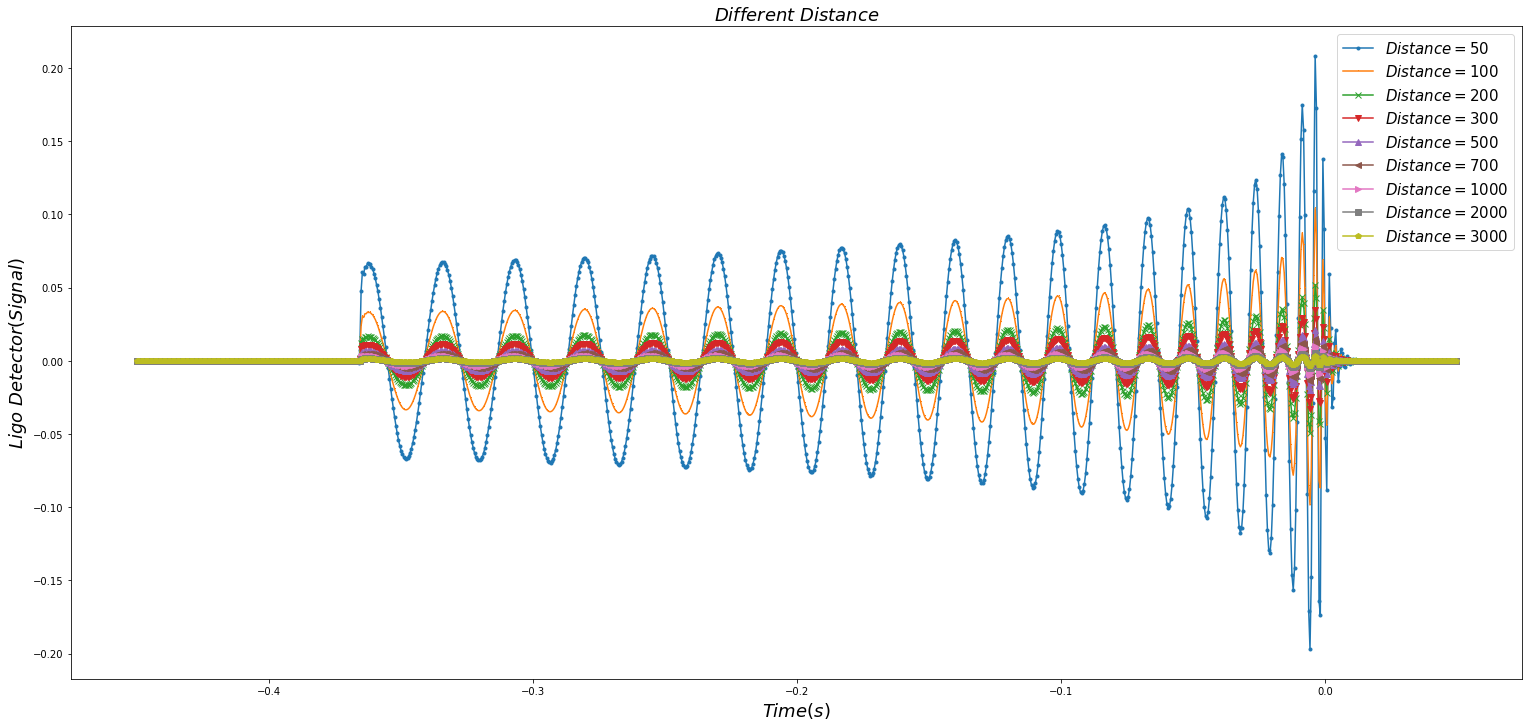

In [ ]:
# distance
marker = [".",",","x","v","^","<",">","s","p","*"]
plt.figure(figsize=(26,12))
for sample_index in range(9):
  mass1 = 20
  mass2 = 20

  inclination = 0
  coa_phase = 0
  distance = [50,100,200,300,500,700,1000,2000,3000][sample_index]

  hp, hc = get_td_waveform( approximant=approximant_method,
                          mass1=mass1,
                          mass2=mass2,
                          inclination=inclination,
                          coa_phase=coa_phase,
                          delta_t=delta_t,
                          distance=distance,
                          f_lower=f_lower)

  time_p = hp.sample_times
  time_c = hc.sample_times

  signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
  time_l1 = signal_l1.sample_times

  min_sim_time = np.min(np.array(time_l1))
  max_sim_time = np.max(np.array(time_l1))
  delta_tt = time_l1[1]-time_l1[0]

  time_l1 = list(time_l1)
  start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
  end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

  time_l1 = start_t + time_l1 + end_t
  time_l1 = np.array(time_l1)

  signal_l1 = list(signal_l1)
  signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
  signal_l1 = np.array(signal_l1)

  time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

  len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
  tsamples =  len(h_range)#int(len_signal / delta_t) + 1

  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

  noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
  noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
  h_range = h_range*factor
  signal = h_range

  plt.plot(time_p_range,signal,label=fr'$Distance={int(distance)}$',marker=marker[sample_index])

  plt.xlabel('$Time(s)$',size=18)
  plt.ylabel('$Ligo\ Detector(Signal)$',size=18)
  plt.title(fr'$Different\ Distance$',size=18)
  plt.legend(fontsize=15)
  plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/distance.jpg',dpi=200,bbox_inches='tight');

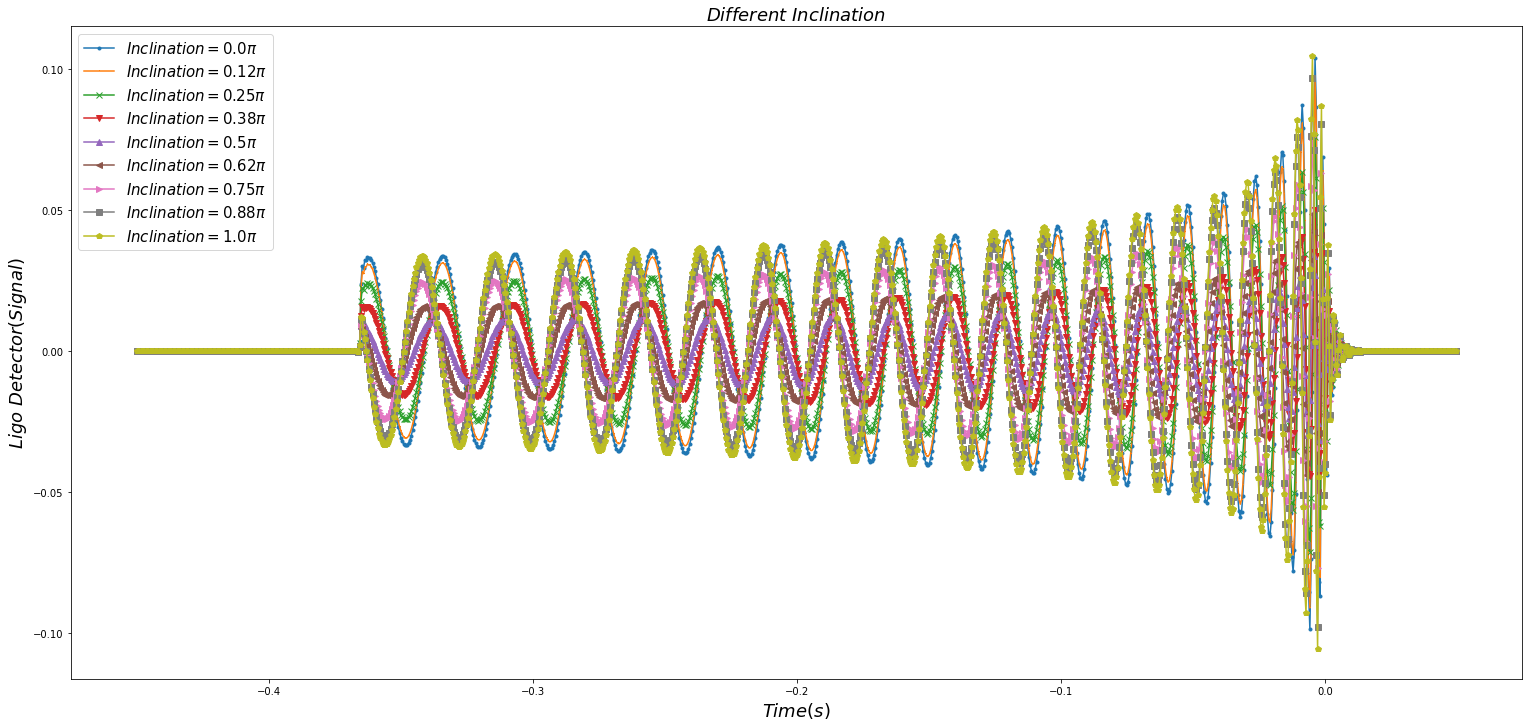

In [ ]:
# inclination
marker = [".",",","x","v","^","<",">","s","p","*"]
plt.figure(figsize=(26,12))
for sample_index in range(9):
  mass1 = 20
  mass2 = 20

  inclination = np.linspace(0,np.pi,9)[sample_index]
  coa_phase = 0
  distance = 100

  hp, hc = get_td_waveform( approximant=approximant_method,
                          mass1=mass1,
                          mass2=mass2,
                          inclination=inclination,
                          coa_phase=coa_phase,
                          delta_t=delta_t,
                          distance=distance,
                          f_lower=f_lower)

  time_p = hp.sample_times
  time_c = hc.sample_times

  signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
  time_l1 = signal_l1.sample_times

  min_sim_time = np.min(np.array(time_l1))
  max_sim_time = np.max(np.array(time_l1))
  delta_tt = time_l1[1]-time_l1[0]

  time_l1 = list(time_l1)
  start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
  end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

  time_l1 = start_t + time_l1 + end_t
  time_l1 = np.array(time_l1)

  signal_l1 = list(signal_l1)
  signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
  signal_l1 = np.array(signal_l1)

  time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

  len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
  tsamples =  len(h_range)#int(len_signal / delta_t) + 1

  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

  noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
  noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
  h_range = h_range*factor
  signal = h_range

  plt.plot(time_p_range,signal,label=fr'$Inclination={np.round(inclination/np.pi,2)}\pi$',marker=marker[sample_index])

  plt.xlabel('$Time(s)$',size=18)
  plt.ylabel('$Ligo\ Detector(Signal)$',size=18)
  plt.title(fr'$Different\ Inclination$',size=18)
  plt.legend(fontsize=15)
  plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/inclination.jpg',dpi=200,bbox_inches='tight');

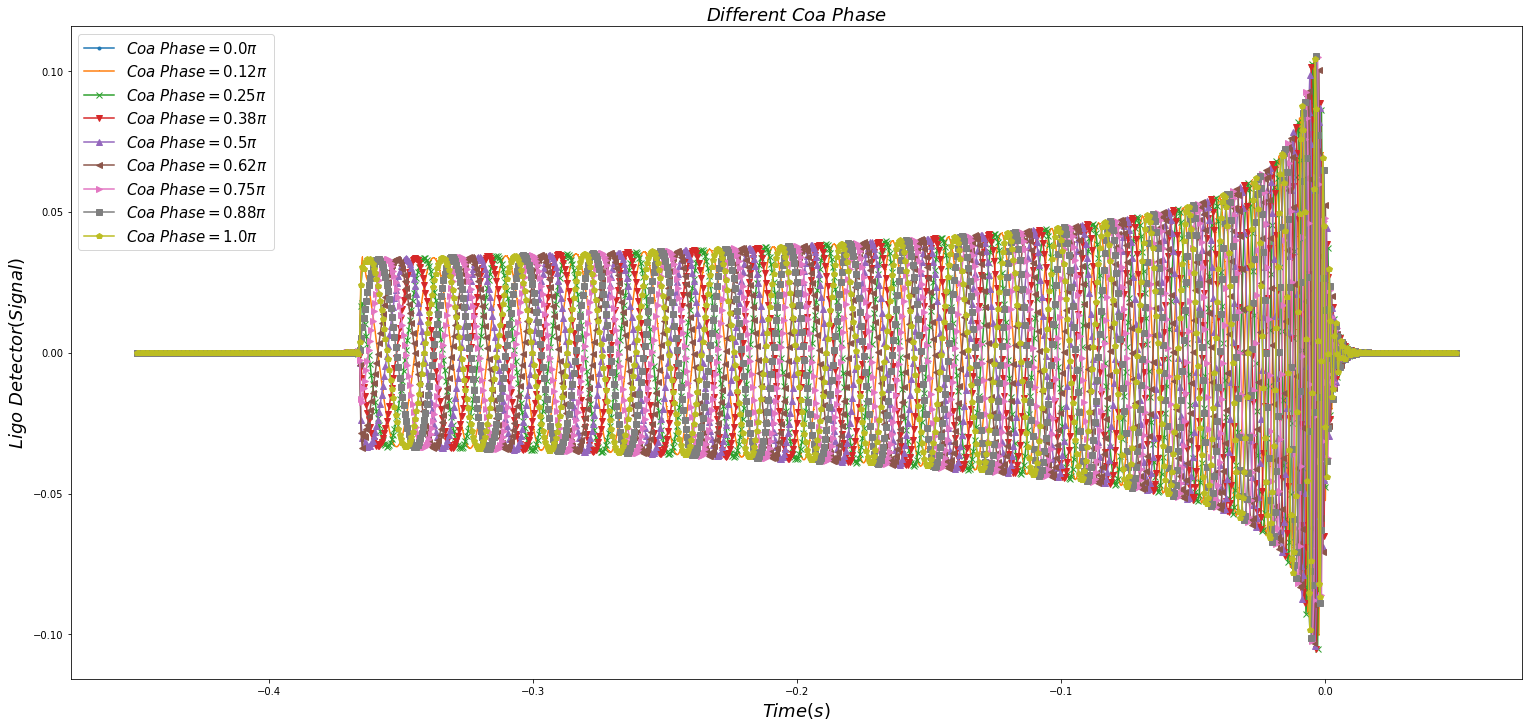

In [ ]:
# coa_phase
marker = [".",",","x","v","^","<",">","s","p","*"]
plt.figure(figsize=(26,12))
for sample_index in range(9):
  mass1 = 20
  mass2 = 20

  inclination = 0
  coa_phase = np.linspace(0,np.pi,9)[sample_index]
  distance = 100

  hp, hc = get_td_waveform( approximant=approximant_method,
                          mass1=mass1,
                          mass2=mass2,
                          inclination=inclination,
                          coa_phase=coa_phase,
                          delta_t=delta_t,
                          distance=distance,
                          f_lower=f_lower)

  time_p = hp.sample_times
  time_c = hc.sample_times

  signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
  time_l1 = signal_l1.sample_times

  min_sim_time = np.min(np.array(time_l1))
  max_sim_time = np.max(np.array(time_l1))
  delta_tt = time_l1[1]-time_l1[0]

  time_l1 = list(time_l1)
  start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
  end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

  time_l1 = start_t + time_l1 + end_t
  time_l1 = np.array(time_l1)

  signal_l1 = list(signal_l1)
  signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
  signal_l1 = np.array(signal_l1)

  time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

  len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
  tsamples =  len(h_range)#int(len_signal / delta_t) + 1

  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

  noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
  noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
  h_range = h_range*factor
  signal = h_range

  plt.plot(time_p_range,signal,label=fr'$Coa\ Phase={np.round(coa_phase/np.pi,2)}\pi$',marker=marker[sample_index])

  plt.xlabel('$Time(s)$',size=18)
  plt.ylabel('$Ligo\ Detector(Signal)$',size=18)
  plt.title(fr'$Different\ Coa\ Phase$',size=18)
  plt.legend(fontsize=15)
  plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/coa_phase.jpg',dpi=200,bbox_inches='tight');

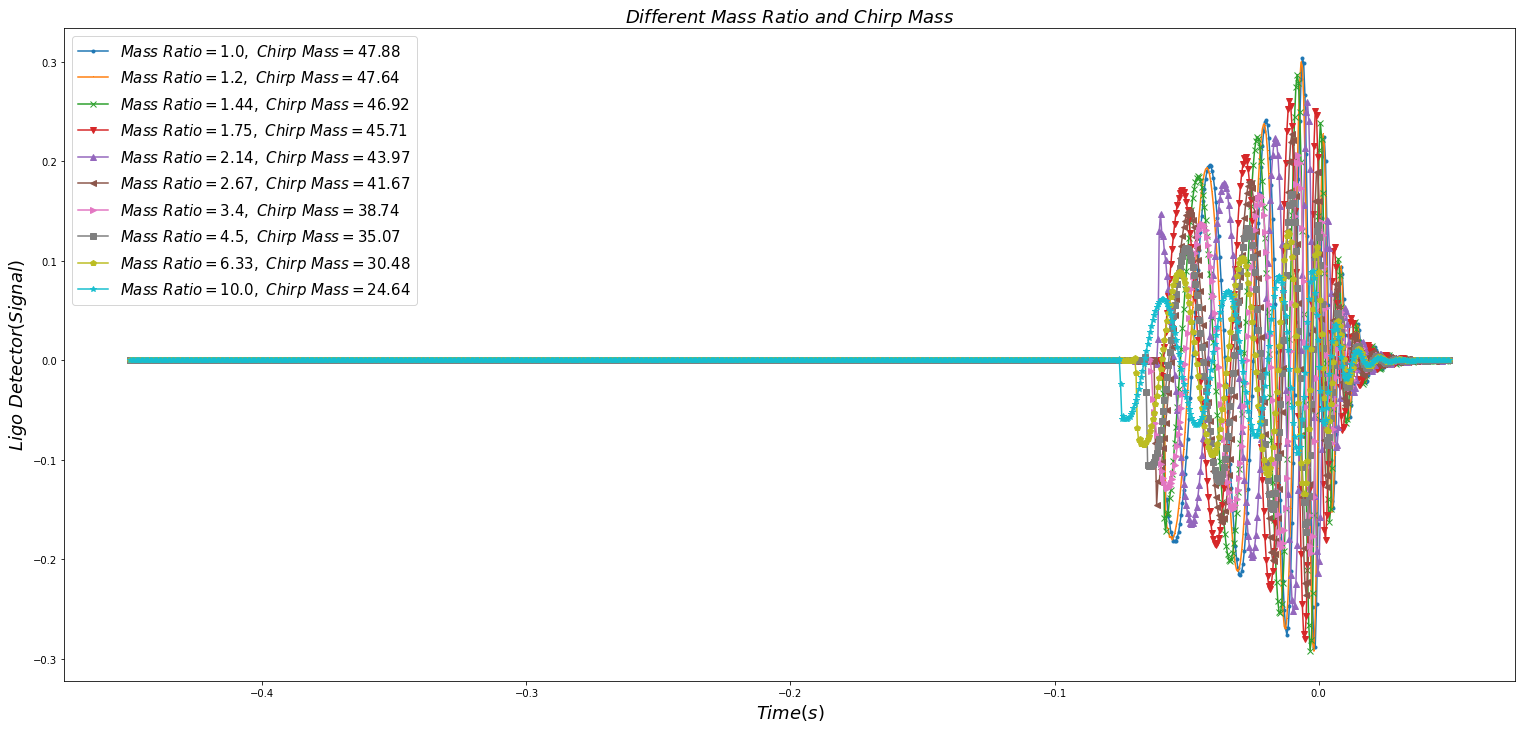

In [ ]:
# mass ratio
marker = [".",",","x","v","^","<",">","s","p","*"]
plt.figure(figsize=(26,12))
for sample_index in range(10):
  mass1 = [55,50,45,40,35,30,25,20,15,10][sample_index]
  mass2 = 110 - [55,50,45,40,35,30,25,20,15,10][sample_index]

  chirp_mass = ((mass1*mass2)**(3/5))/((mass1+mass2)**(1/5))
  mass_ratio = max(mass2/mass1,mass1/mass2)

  inclination = 0
  coa_phase = 0
  distance = 100

  hp, hc = get_td_waveform( approximant=approximant_method,
                          mass1=mass1,
                          mass2=mass2,
                          inclination=inclination,
                          coa_phase=coa_phase,
                          delta_t=delta_t,
                          distance=distance,
                          f_lower=f_lower)

  time_p = hp.sample_times
  time_c = hc.sample_times

  signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
  time_l1 = signal_l1.sample_times

  min_sim_time = np.min(np.array(time_l1))
  max_sim_time = np.max(np.array(time_l1))
  delta_tt = time_l1[1]-time_l1[0]

  time_l1 = list(time_l1)
  start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
  end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

  time_l1 = start_t + time_l1 + end_t
  time_l1 = np.array(time_l1)

  signal_l1 = list(signal_l1)
  signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
  signal_l1 = np.array(signal_l1)

  time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

  len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
  tsamples =  len(h_range)#int(len_signal / delta_t) + 1

  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

  noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
  noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
  h_range = h_range*factor
  signal = h_range

  plt.plot(time_p_range,signal,label=fr'$Mass\ Ratio={np.round(mass_ratio,2)},\ Chirp\ Mass={np.round(chirp_mass,2)}$',marker=marker[sample_index])

  plt.xlabel('$Time(s)$',size=18)
  plt.ylabel('$Ligo\ Detector(Signal)$',size=18)
  plt.title(fr'$Different\ Mass\ Ratio\ and\ Chirp\ Mass$',size=18)
  plt.legend(fontsize=15)
  plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/mass_ratio_chirp_mass.jpg',dpi=200,bbox_inches='tight');

In [ ]:
# # mass ratio
# marker = [".",",","x","v","^","<",">","s","p","*"]
# plt.figure(figsize=(26,12))
# for sample_index in range(10):
#   mass1 = [55,50,45,40,35,30,25,20,15,10][sample_index]
#   mass2 = 110 - [55,50,45,40,35,30,25,20,15,10][sample_index]

#   chirp_mass = ((mass1*mass2)**(3/5))/((mass1+mass2)**(1/5))
#   mass_ratio = max(mass2/mass1,mass1/mass2)

#   inclination = 0
#   coa_phase = 0
#   distance = 100

#   hp, hc = get_td_waveform( approximant=approximant_method,
#                           mass1=mass1,
#                           mass2=mass2,
#                           inclination=inclination,
#                           coa_phase=coa_phase,
#                           delta_t=delta_t,
#                           distance=distance,
#                           f_lower=f_lower)

#   time_p = hp.sample_times
#   time_c = hc.sample_times

#   signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
#   time_l1 = signal_l1.sample_times

#   min_sim_time = np.min(np.array(time_l1))
#   max_sim_time = np.max(np.array(time_l1))
#   delta_tt = time_l1[1]-time_l1[0]

#   time_l1 = list(time_l1)
#   start_t = list(np.arange(min(tmin,min_sim_time),min_sim_time,delta_tt))
#   end_t   = list(np.arange(max_sim_time+delta_tt,max(max_sim_time,tmax)+delta_tt,delta_tt))

#   time_l1 = start_t + time_l1 + end_t
#   time_l1 = np.array(time_l1)

#   signal_l1 = list(signal_l1)
#   signal_l1 = list(np.zeros((len(start_t)))) + signal_l1 + list(np.zeros((len(end_t))))
#   signal_l1 = np.array(signal_l1)

#   time_p_range,h_range = ens_interpolation(h = signal_l1,t = time_l1,tmin=tmin,tmax=tmax,delta_t=delta_t)

#   len_signal = time_p_range[-1]-time_p_range[0] # In terms of the seconds
#   tsamples =  len(h_range)#int(len_signal / delta_t) + 1

#   psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

#   noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
#   noise_signal_weighted = np.array(noise_signal)*factor # *w_noise
#   h_range = h_range*factor
#   signal = h_range

#   plt.plot(time_p_range,signal,label=fr'$Mass\ Ratio={np.round(mass_ratio,2)}$',marker=marker[sample_index])

#   plt.xlabel('$Time(s)$',size=18)
#   plt.ylabel('$Ligo\ Detector(Signal)$',size=18)
#   plt.title(fr'$Different\ Mass\ Ratio$',size=18)
#   plt.legend(fontsize=15)
#   plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/mass_ratio.jpg',dpi=200,bbox_inches='tight');

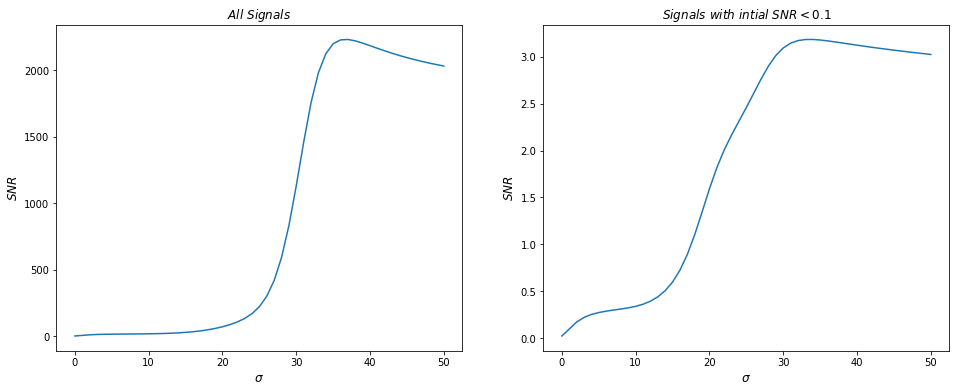

In [ ]:
signal_data = np.load('/content/drive/MyDrive/TDA_Esfahanian/data_sim/signal_data.npz')['data']
noise_data = np.load('/content/drive/MyDrive/TDA_Esfahanian/data_sim/noise_data.npz')['data']
df = pd.read_csv('/content/drive/MyDrive/TDA_Esfahanian/data_sim/df_label.csv')

list_snr = df['SNR'].values

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
list_s = np.arange(0,51,1)
snr_s = []
for s in list_s:
    list_s_i = []
    for i in range(199):
        d = signal_data[i].copy()
        n = noise_data[i].copy()
        if np.var(d)/np.var(n) < 10000.1:
            f = gf(d+n,s)
            n = gf(n,s)
            d = f-n
            list_s_i.append(np.var(d)/np.var(n))
    snr_s.append(np.mean(list_s_i))

plt.plot(list_s,snr_s)

plt.xlabel('$\sigma$',size = 12)
plt.ylabel('$SNR$',size = 12)
plt.title(fr'$All\ Signals$')

plt.subplot(1,2,2)
list_s = np.arange(0,51,1)
snr_s = []
for s in list_s:
    list_s_i = []
    for i in range(199):
        d = signal_data[i].copy()
        n = noise_data[i].copy()
        if np.var(d)/np.var(n) < 0.1:
            f = gf(d+n,s)
            n = gf(n,s)
            d = f-n
            list_s_i.append(np.var(d)/np.var(n))
    snr_s.append(np.mean(list_s_i))

plt.plot(list_s,snr_s)

plt.xlabel('$\sigma$',size = 12)
plt.ylabel('$SNR$',size = 12)
plt.title(fr'$Signals\ with\ intial\ SNR<0.1$')
# plt.legend()
plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/SNR_smooth_0.jpg',dpi=250,bbox_inches='tight');

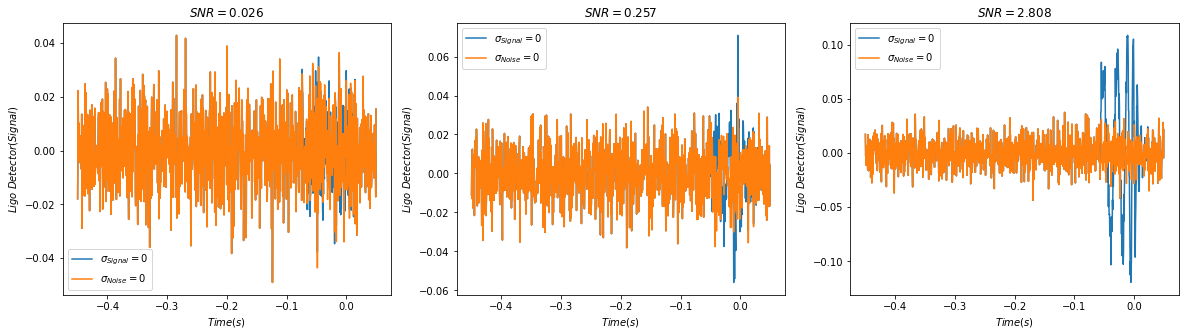

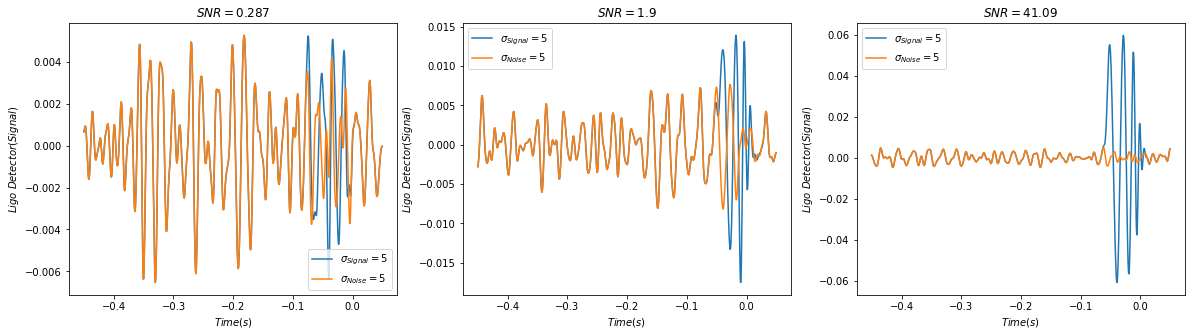

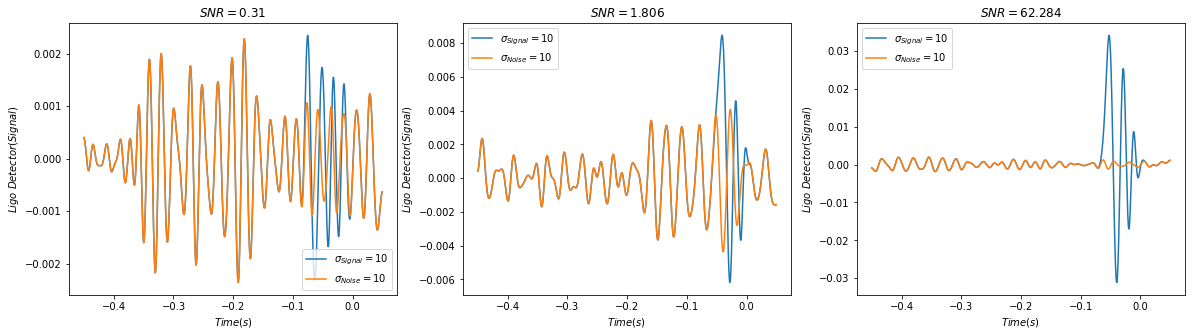

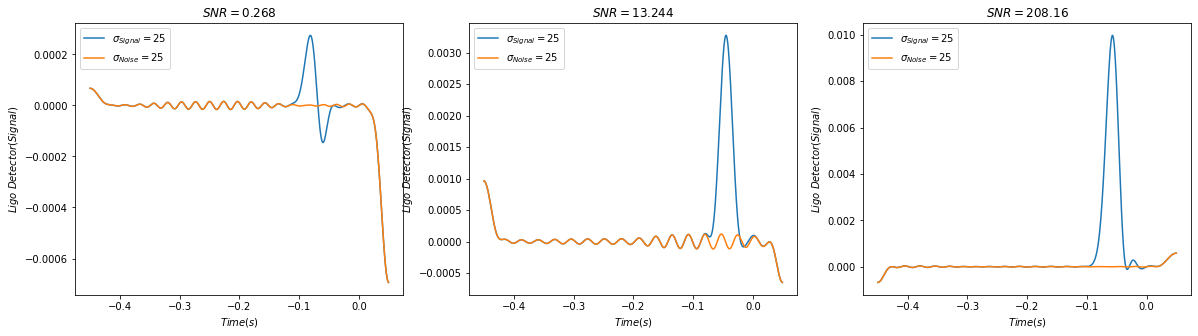

In [ ]:
for sigma in [0,5,10,25]:
  k = 0
  plt.figure(figsize=(20,5))
  for i in [0,2,15]:
    k+=1
    h_range = signal_data[i]
    noise_signal_weighted = noise_data[i]
    signal = gf(h_range + noise_signal_weighted,sigma)
    noise_signal_weighted = gf(noise_signal_weighted,sigma)
    h_range = signal - noise_signal_weighted

    plt.subplot(1,3,k)

    plt.plot(time_p_range,signal,label=r'$\sigma_{Signal}$'+fr'$={sigma}$')
    plt.plot(time_p_range,noise_signal_weighted,label=r'$\sigma_{Noise}$'+fr'$={sigma}$')

    plt.xlabel('$Time(s)$')
    plt.ylabel('$Ligo\ Detector(Signal)$')
    plt.title(fr'$SNR={np.round(np.var(h_range)/np.var(noise_signal_weighted),3)}$')
    plt.legend()
  plt.savefig(f'/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/SNR_sigma_{sigma}.jpg',dpi=250,bbox_inches='tight')
  plt.show();